In [1]:
# https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
# https://colab.research.google.com/github/rpi-techfundamentals/website_spring_2020/blob/master/content/notebooks/20-deep-learning1/06-regression-bh-pytorch.ipynb#scrollTo=xD9PhAU7hoqT
#!pip install torchvision
import numpy as np
import pandas as pd
import pyreadr
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
#Define the model 
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.autograd import Variable
from sklearn.metrics import r2_score


In [2]:
print(torch.__version__)

1.4.0


In [3]:
TrainSet_eonr2_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/TrainSet_eonr2.rds")[None] # also works for RData
TrainSet_eonr2_df.head()

,eonr,rain_30,rain_60,rain_90,t_max_30,t_max_60,t_max_90,t_min_30,t_min_60,t_min_90,...,day_sow,day_v5,lai_v5,whc,oc_20cm_v5,sw_dep_v5,n_0_60cm_v5,surfaceom_wt_v5,sand_40cm,clay_40cm
0,190.0,125.0,229.0,17.0,22.050000,15.216667,8.250000,9.900000,3.533333,-4.633333,...,112.0,152.0,0.408,244.0,0.87775,666.043,39.3,444.3,4.0,24.571034
1,210.0,140.0,108.0,19.0,22.133333,15.933333,3.383333,10.300000,2.950000,-6.650000,...,112.0,147.0,0.402,244.0,0.88350,697.709,42.7,511.8,4.0,24.571034
2,200.0,63.0,52.0,26.0,21.733333,14.183333,6.750000,7.716667,1.550000,-3.666667,...,112.0,154.0,0.388,244.0,0.86900,670.037,21.2,84.1,4.0,24.571034
3,290.0,122.0,98.0,141.0,22.333333,15.033333,8.133333,11.050000,2.866667,-2.800000,...,112.0,148.0,0.308,244.0,0.88475,675.283,4.7,613.6,4.0,24.571034
4,160.0,103.0,171.0,77.0,20.333333,13.616667,3.450000,8.333333,2.900000,-5.066667,...,112.0,154.0,0.410,244.0,0.87900,690.324,41.4,408.2,4.0,24.571034


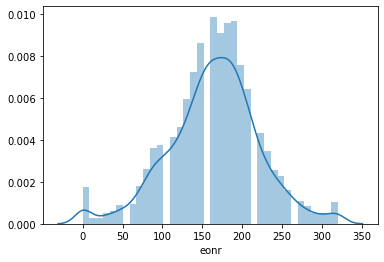

In [4]:
#Let's us seaborn, because it is pretty. ;) 
#See more here. http://seaborn.pydata.org/tutorial/distributions.html
sns.distplot(TrainSet_eonr2_df['eonr']);

In [5]:
y_train = TrainSet_eonr2_df['eonr']
X_train = TrainSet_eonr2_df.drop('eonr', axis=1)
print(X_train.shape, y_train.shape)

(4456, 21) (4456,)


In [6]:
#Define training hyperprameters.
batch_size = 50
num_epochs = 200
learning_rate = 0.01
size_hidden= 100

#Calculate some other hyperparameters based on data.  
batch_no = len(X_train) // batch_size  #batches
cols=X_train.shape[1] #Number of columns in input matrix
n_output=1

In [7]:
#Create the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print("Executing the model on :",device)
class Net(torch.nn.Module):
    def __init__(self, n_feature, size_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(cols, size_hidden)   # hidden layer
        self.predict = torch.nn.Linear(size_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
net = Net(cols, size_hidden, n_output)

Executing the model on : cuda:0


In [8]:
#Adam is a specific flavor of gradient decent which is typically better
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
criterion = torch.nn.MSELoss(size_average=False)  # this is for regression mean squared loss

/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [9]:
X_train=X_train.values
y_train=y_train.values

In [10]:
running_loss = 0.0
for epoch in range(num_epochs):
    #Shuffle just mixes up the dataset between epocs
    X_train, y_train = shuffle(X_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(X_train[start:end]))
        labels = Variable(torch.FloatTensor(y_train[start:end]))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print("outputs",outputs)
        #print("outputs",outputs,outputs.shape,"labels",labels, labels.shape)
        loss = criterion(outputs, torch.unsqueeze(labels,dim=1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}'.format(epoch+1), "loss: ",running_loss)
    running_loss = 0.0


Epoch 1 loss:  107391559.40625
Epoch 2 loss:  14295148.5
Epoch 3 loss:  14063231.2421875
Epoch 4 loss:  14974142.5625
Epoch 5 loss:  13038672.4375
Epoch 6 loss:  12719472.625
Epoch 7 loss:  13972702.1796875
Epoch 8 loss:  13679330.5390625
Epoch 9 loss:  12834321.65625
Epoch 10 loss:  12062212.5546875
Epoch 11 loss:  13936043.9921875
Epoch 12 loss:  12266165.40625
Epoch 13 loss:  12467767.6015625
Epoch 14 loss:  11467601.359375
Epoch 15 loss:  12469373.92578125
Epoch 16 loss:  11109083.796875
Epoch 17 loss:  10845893.26953125
Epoch 18 loss:  11294526.53125
Epoch 19 loss:  12506275.2421875
Epoch 20 loss:  10844447.078125
Epoch 21 loss:  12484132.234375
Epoch 22 loss:  10814096.7890625
Epoch 23 loss:  11973084.65234375
Epoch 24 loss:  11282121.640625
Epoch 25 loss:  10097557.0078125
Epoch 26 loss:  10602050.453125
Epoch 27 loss:  10673113.2890625
Epoch 28 loss:  10100795.44921875
Epoch 29 loss:  10267541.125
Epoch 30 loss:  10479053.609375
Epoch 31 loss:  10365333.3671875
Epoch 32 loss:  

In [11]:
#import pandas as pd
X = Variable(torch.FloatTensor(X_train)) 
result = net(X)
pred=result.data[:,0].numpy()
print(len(pred),len(y_train))
r2_score(pred,y_train)

4456 4456


-0.6689156698410685

In [12]:
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData
prediction_set_aggregated_df.head()

,id_10,id_field,region,z,rain_30,rain_60,rain_90,t_max_30,t_max_60,t_max_90,...,day_v5,lai_v5,whc,oc_20cm_v5,sw_dep_v5,n_0_60cm_v5,surfaceom_wt_v5,sand_40cm,clay_40cm,area_ha
0,5,3.0,3.0,11,125.0,229.0,17.0,22.050000,15.216667,8.250000,...,152.0,0.408,294.075688,1.620588,629.483784,35.048204,465.378891,5.071375,21.024234,40.0
1,5,3.0,3.0,13,140.0,108.0,19.0,22.133333,15.933333,3.383333,...,147.0,0.402,294.075688,1.625338,666.127141,42.310082,511.010443,5.071375,21.024234,40.0
2,5,3.0,3.0,15,96.0,101.0,39.0,20.666667,16.783333,9.250000,...,157.0,0.406,294.075688,1.622531,620.573678,46.126236,497.375201,5.071375,21.024234,40.0
3,5,3.0,3.0,17,96.0,47.0,33.0,22.016667,17.066667,9.600000,...,157.0,0.397,294.075688,1.620151,629.544435,70.271481,462.792524,5.071375,21.024234,40.0
4,5,3.0,3.0,19,43.0,183.0,51.0,23.916667,12.283333,8.650000,...,147.0,0.398,294.075688,1.623718,623.843297,47.598318,721.119533,5.071375,21.024234,40.0


In [13]:
X_pred = prediction_set_aggregated_df[['rain_30', 'rain_60','rain_90', 't_max_30', 't_max_60', 't_max_90', 't_min_30', 't_min_60', 't_min_90', 'Y_prev',
 'Y_corn_lt_avg', 'day_sow', 'day_v5', 'lai_v5', 'whc', 'oc_20cm_v5', 'sw_dep_v5', 'n_0_60cm_v5', 'surfaceom_wt_v5', 'sand_40cm', 'clay_40cm']]
X_pred=X_pred.values
X_pred

array([[125.        , 229.        ,  17.        , ..., 465.37889136,
          5.07137482,  21.02423362],
       [140.        , 108.        ,  19.        , ..., 511.01044335,
          5.07137482,  21.02423362],
       [ 96.        , 101.        ,  39.        , ..., 497.37520121,
          5.07137482,  21.02423362],
       ...,
       [141.        , 124.        , 120.        , ..., 211.43236352,
         20.46973879,  19.59067624],
       [190.        ,  16.        , 132.        , ...,  94.55417258,
         20.46973879,  19.59067624],
       [ 94.        , 143.        , 214.        , ..., 142.36507711,
         20.46973879,  19.59067624]])

In [14]:
#This is a little bit tricky to get the resulting prediction.  
def calculate_r2(x,y=[]):
    """
    This function will return the r2 if passed x and y or return predictions if just passed x. 
    """
    # Evaluate the model with the test set. 
    X = Variable(torch.FloatTensor(x))  
    result = net(X) #This outputs the value for regression
    result=result.data[:,0].numpy()
  
    if len(y) != 0:
        r2=r2_score(result, y)
        print("R-Squared", r2)
        #print('Accuracy {:.2f}'.format(num_right / len(y)), "for a total of ", len(y), "records")
        return pd.DataFrame(data= {'actual': y, 'predicted': result})
    else:
        print("returning predictions")
        return result


In [15]:
# Evaluate the model with the test set. 
X = Variable(torch.FloatTensor(X_pred)) 
y_pred = net(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()
y_pred

array([119.999306, 166.68637 , 155.75237 , ..., 173.631   , 236.6117  ,
       207.03128 ], dtype=float32)

In [16]:
prediction_set_aggregated_df['eonr_pred'] = y_pred
prediction_set_aggregated_df.head

<bound method NDFrame.head of        id_10  id_field  region   z  rain_30  rain_60  rain_90   t_max_30  \
0          5       3.0     3.0  11    125.0    229.0     17.0  22.050000   
1          5       3.0     3.0  13    140.0    108.0     19.0  22.133333   
2          5       3.0     3.0  15     96.0    101.0     39.0  20.666667   
3          5       3.0     3.0  17     96.0     47.0     33.0  22.016667   
4          5       3.0     3.0  19     43.0    183.0     51.0  23.916667   
...      ...       ...     ...  ..      ...      ...      ...        ...   
60362   1526       1.0     1.0  29    251.0    117.0     53.0  23.083333   
60363   1526       1.0     1.0   3    138.0     79.0    107.0  22.150000   
60364   1526       1.0     1.0   5    141.0    124.0    120.0  21.766667   
60365   1526       1.0     1.0   7    190.0     16.0    132.0  21.750000   
60366   1526       1.0     1.0   9     94.0    143.0    214.0  20.516667   

        t_max_60   t_max_90  ...  lai_v5         whc  oc_

In [ ]:
# now let's write a Rds
pyreadr.write_rds("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_cnn_dt.rds", prediction_set_aggregated_df)